In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Boston Housing Dataset

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per \$10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the Black population proportion by town
* LSTAT - \% lower status of the population
* MEDV - Median value of owner-occupied homes in \$1000's

In [4]:
df = pd.read_csv("../example_data/housing.csv", header=None, sep='\s+')
df.columns = ["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "black", "lstat", "medv"]
df = df[df["medv"] < 50]

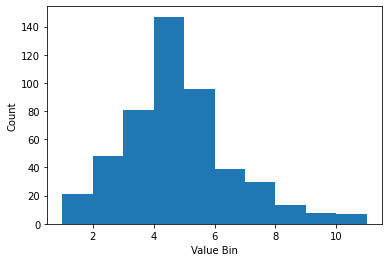

In [17]:
# The outcome variable is medv, the house price value. Let's discretize it into bins so that we can
# calculate entropy, etc.

num_bins = 10
outcome_bins = np.histogram_bin_edges(df["medv"], bins=num_bins)
discrete_outcomes = np.digitize(df["medv"], bins=outcome_bins)

plt.hist(discrete_outcomes)
plt.xlabel("Value Bin")
plt.ylabel("Count");

In [5]:
def discretize_data(df, spec):
    discrete_columns = {}
    for col, col_spec in spec.items():
        if col_spec["method"] == "keep":
            discrete_columns[col] = df[col].values
        elif col_spec["method"] == "bin":
            discrete_columns[col] = np.digitize(df[col], col_spec["bins"])
    return pd.DataFrame(discrete_columns, index=df.index)

discrete_df = discretize_data(df, {
    "crim": { "method": "bin", "bins": [np.mean(df["crim"])] },
    "zn": { "method": "bin", "bins": [1.0] },
    "indus": { "method": "bin", "bins": np.quantile(df["indus"], [0.25, 0.5, 0.75]) },
    "chas": { "method": "keep" },
    "nox": { "method": "bin", "bins": np.quantile(df["nox"], [0.25, 0.5, 0.75]) },
    "rm": { "method": "bin", "bins": np.quantile(df["rm"], [0.25, 0.5, 0.75]) },
    "age": { "method": "bin", "bins": np.quantile(df["age"], [0.25, 0.5, 0.75]) },
    "dis": { "method": "bin", "bins": np.quantile(df["dis"], [0.25, 0.5, 0.75]) },
    "rad": { "method": "bin", "bins": np.quantile(df["rad"], [0.25, 0.5, 0.75]) },
    "tax": { "method": "bin", "bins": np.quantile(df["tax"], [0.25, 0.5, 0.75]) },
    "ptratio": { "method": "bin", "bins": np.quantile(df["ptratio"], [0.25, 0.5, 0.75]) },
    "black": { "method": "bin", "bins": np.quantile(df["black"], [0.25, 0.5, 0.75]) },
    "lstat": { "method": "bin", "bins": np.quantile(df["lstat"], [0.25, 0.5, 0.75]) },
})

In [21]:
def calc_entropy(inputs):
    """
    Calculates the Shannon entropy of the given inputs, where inputs is an
    array or series of discrete values.
    """
    unique, counts = np.unique(inputs, return_counts=True)
    return -np.sum((counts / len(inputs)) * np.log2(counts / len(inputs)))
    
def entropy_difference(outcomes, mask):
    """
    Calculates a score that is higher when the distribution of outcomes 
    inside the given mask has a LOWER entropy than the distribution
    overall.
    
    Args:
        outcomes: A 1D or 2D array of discrete outcome values.
        mask: A 1D boolean array indicating whether each row
            is part of the slice being evaluated or not.
    """
    if len(outcomes.shape) > 1:
        return sum([calc_entropy(outcomes[:,i]) / calc_entropy(outcomes[mask,i])
                    for i in range(outcomes.shape[1])]) / outcomes.shape[1]
    else:
        return calc_entropy(outcomes) / calc_entropy(outcomes[mask])

def mean_difference_l1(outcomes, mask):
    """
    Calculates a score that is higher when there is a larger difference
    between the average outcomes inside the given mask and the overall
    dataset, normalized by the population standard deviation.
    
    Args:
        outcomes: A 1D or 2D array of discrete (but ordered) outcome
            values.
        mask: A 1D boolean array indicating whether each row
            is part of the slice being evaluated or not.
    """
    if len(outcomes.shape) > 1:
        return np.abs(np.mean((outcomes[mask].mean(axis=0) - outcomes.mean(axis=0)) / outcomes.std(axis=0)))
    else:
        return (outcomes[mask].mean() - outcomes.mean()) / outcomes.std()
    
def group_size(outcomes, mask):
    return np.log2(1 + mask.sum() / len(mask))

27 examples in slice
Entropy score: 1.066727205923479
Difference score: 1.1916646422283717
Group size score: 0.07738253131236406


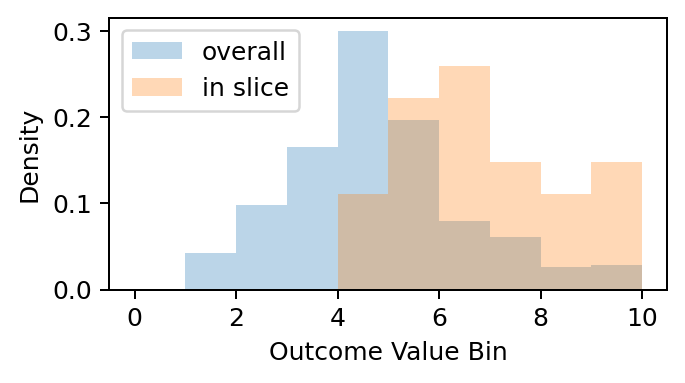

In [30]:
# A slice is defined by a set of pairs of columns and the values they take: [(col name, value)...]
# For instance, here we select a slice where all instances have the "indus" field with value 0
# and the "dis" field with value 2.
example_slice = (discrete_df["indus"] == 0) & (discrete_df["dis"] == 2)
print(example_slice.sum(), "examples in slice")

print("Entropy score:", entropy_difference(discrete_outcomes, example_slice))
print("Difference score:", mean_difference_l1(discrete_outcomes, example_slice))
print("Group size score:", group_size(discrete_outcomes, example_slice))

# Plot the difference in outcomes using a histogram
plt.figure(figsize=(4, 2), dpi=180)
plt.hist(discrete_outcomes, bins=np.arange(num_bins + 1), alpha=0.3, density=True, label='overall')
plt.hist(discrete_outcomes[example_slice], bins=np.arange(num_bins + 1), alpha=0.3, density=True, label='in slice')
plt.xlabel("Outcome Value Bin")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
# Implement a function that brute-force searches all possible slices of at most M features,
# and returns the top K slices